# Importing libraries

In [318]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Reading the training dataset

In [319]:
train_data= pd.read_csv('train.tsv', sep="\t", names = ['ID','Label','Statement','Subject','Speaker','Speakers Job Title','State Info','Party Affiliation','Total credit history count','false counts',' half true counts','mostly true counts','pants on fire counts','The Context'])
train_data.head(5)
train_data.shape

(10240, 14)

# Reading test dataset

In [320]:
test_data= pd.read_csv('test.tsv', sep="\t", names = ['ID','Label','Statement','Subject','Speaker','Speakers Job Title','State Info','Party Affiliation','Total credit history count','false counts',' half true counts','mostly true counts','pants on fire counts','The Context'])
test_data.head(5)

,ID,Label,Statement,Subject,Speaker,Speakers Job Title,State Info,Party Affiliation,Total credit history count,false counts,half true counts,mostly true counts,pants on fire counts,The Context
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


# Preprocessing / Cleaning the data

In [321]:
train_data.isnull().values.any()
test_data.isnull().values.any()

True

In [322]:
train_data=train_data.replace(np.nan,'NA',regex=True)

In [323]:

test_data=train_data.replace(np.nan,'NA',regex=True)

In [324]:
train_data.isnull().values.any()

False

In [325]:

test_data.isnull().values.any()

False

In [326]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [327]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [328]:
train_data['Statement'] = train_data['Statement'].apply(stopwords)
train_data.head(5)

,ID,Label,Statement,Subject,Speaker,Speakers Job Title,State Info,Party Affiliation,Total credit history count,false counts,half true counts,mostly true counts,pants on fire counts,The Context
0,2635.json,false,says annies list political group supports thir...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,decline coal start? started natural gas took s...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"hillary clinton agrees john mccain ""by voting ...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,health care reform legislation likely mandate ...,health-care,blog-posting,NA,NA,none,7,19,3,5,44,a news release
4,9028.json,half-true,economic turnaround started end term.,"economy,jobs",charlie-crist,NA,Florida,democrat,15,9,20,19,2,an interview on CNN


In [329]:
test_data['Statement'] = test_data['Statement'].apply(stopwords)
test_data.head(5)

,ID,Label,Statement,Subject,Speaker,Speakers Job Title,State Info,Party Affiliation,Total credit history count,false counts,half true counts,mostly true counts,pants on fire counts,The Context
0,2635.json,false,says annies list political group supports thir...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,decline coal start? started natural gas took s...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"hillary clinton agrees john mccain ""by voting ...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,health care reform legislation likely mandate ...,health-care,blog-posting,NA,NA,none,7,19,3,5,44,a news release
4,9028.json,half-true,economic turnaround started end term.,"economy,jobs",charlie-crist,NA,Florida,democrat,15,9,20,19,2,an interview on CNN


#Stemming

In [330]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [331]:
train_data['Statement'] = train_data['Statement'].apply(stemming)




In [332]:
test_data['Statement'] = test_data['Statement'].apply(stemming)
test_data.head(5)
test_data.dropna()

,ID,Label,Statement,Subject,Speaker,Speakers Job Title,State Info,Party Affiliation,Total credit history count,false counts,half true counts,mostly true counts,pants on fire counts,The Context
0,2635.json,false,say anni list polit group support third-trimes...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,declin coal start? start natur gas took start ...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"hillari clinton agre john mccain ""bi vote give...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,health care reform legisl like mandat free sex...,health-care,blog-posting,NA,NA,none,7,19,3,5,44,a news release
4,9028.json,half-true,econom turnaround start end term.,"economy,jobs",charlie-crist,NA,Florida,democrat,15,9,20,19,2,an interview on CNN
5,12465.json,true,chicago bear start quarterback last 10 year to...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece
6,2342.json,barely-true,jim dunnam live district repres year now.,candidates-biography,republican-party-texas,NA,Texas,republican,3,1,1,3,1,a press release.
7,153.json,half-true,"i'm person stage work activ last year passing,...",ethics,barack-obama,President,Illinois,democrat,70,71,160,163,9,"a Democratic debate in Philadelphia, Pa."
8,5602.json,half-true,"however, took $19.5 million oregon lotteri fun...",jobs,oregon-lottery,NA,NA,organization,0,0,1,0,1,a website
9,9741.json,mostly-true,say gop primari oppon glenn grothman joe leibh...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0,0,0,1,0,an online video


In [333]:

data_text = train_data[['Statement']]
data_text['index'] = data_text.index
documents = data_text

In [334]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

In [335]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/barkhachoithani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [336]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go


# Applying lemmitization and stemming

In [337]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [338]:
doc_sample = documents[documents['index'] == 4310].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['member', 'public', 'charg', '$50', 'hear', 'gov.', 'scott', 'walker', 'dozen', 'member', 'administr', 'talk', 'job', 'economi', 'lambeau', 'field.']


 tokenized and lemmatized document: 
['member', 'public', 'charg', 'hear', 'scott', 'walker', 'dozen', 'member', 'administr', 'talk', 'economi', 'lambeau', 'field']


# Sentiment Analysis - News is Fake or not

#creating word features

In [339]:
# This is how the Naive Bayes classifier expects the input
def create_word_features(words):
    useful_words = [word for word in words if word not in stopwords.words("english")]
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

In [340]:
train_data['Label'] = pd.Series(train_data['Label'])

#slicing the data

In [341]:
data_slice = train_data[['Label','Statement']]
data_slice.head(20)

,Label,Statement
0,false,say anni list polit group support third-trimes...
1,half-true,declin coal start? start natur gas took start ...
2,mostly-true,"hillari clinton agre john mccain ""bi vote give..."
3,false,health care reform legisl like mandat free sex...
4,half-true,econom turnaround start end term.
5,true,chicago bear start quarterback last 10 year to...
6,barely-true,jim dunnam live district repres year now.
7,half-true,"i'm person stage work activ last year passing,..."
8,half-true,"however, took $19.5 million oregon lotteri fun..."
9,mostly-true,say gop primari oppon glenn grothman joe leibh...


#visualising the features

In [345]:
True_len = data_slice[data_slice['Label'] == 'true'].shape[0]
False_len = data_slice[data_slice['Label'] == 'false'].shape[0]
Barely_true_len = data_slice[data_slice['Label'] == 'barely-true'].shape[0]
Mostly_true_len = data_slice[data_slice['Label'] == 'mostly-true'].shape[0]
Half_true_len = data_slice[data_slice['Label'] == 'half-true'].shape[0]
Pants_fire_len = data_slice[data_slice['Label'] == 'pants-fire'].shape[0]

In [346]:
print(True_len)

1676


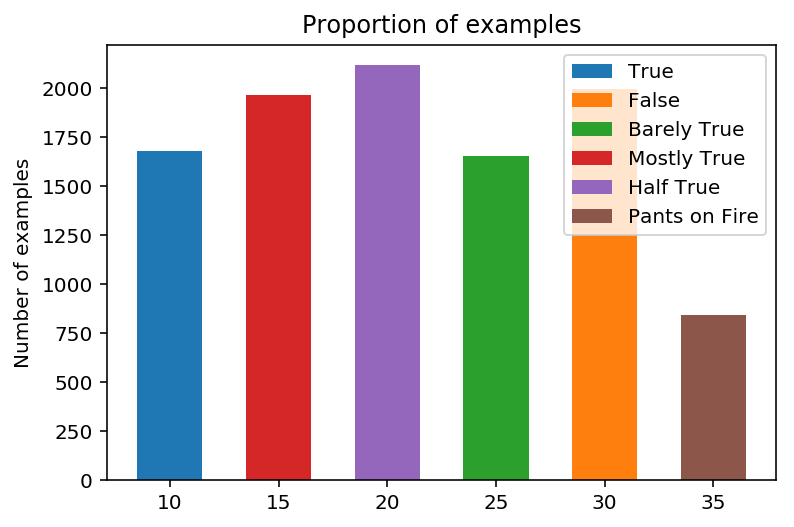

In [347]:
import matplotlib
from matplotlib import pyplot as plt

plt.bar(10, True_len,3, label="True")
plt.bar(30,False_len,3, label="False")
plt.bar(25,Barely_true_len,3, label="Barely True")
plt.bar(15,Mostly_true_len,3, label="Mostly True")
plt.bar(20,Half_true_len,3, label="Half True")
plt.bar(35,Pants_fire_len,3, label="Pants on Fire")

plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

# classes representing not fake news sentiment

In [357]:
temp_data_slice_true = data_slice.loc[(data_slice['Label'] == 'half-true') | (data_slice['Label'] == 'mostly-true') | (data_slice['Label'] == 'true')]
temp_data_slice_true.head(5)

,Label,Statement
1,half-true,declin coal start? start natur gas took start ...
2,mostly-true,"hillari clinton agre john mccain ""bi vote give..."
4,half-true,econom turnaround start end term.
5,true,chicago bear start quarterback last 10 year to...
7,half-true,"i'm person stage work activ last year passing,..."


In [358]:
data_text_true = temp_data_slice_true[['Statement']]
data_text_true['index'] = data_text_true.index
documents_true = data_text_true

In [359]:
doc_sample_true = documents_true[documents_true['index'] == 1].values[0][0]
print('original document: ')
words_true = []
for word_true in doc_sample_true.split(' '):
    words_true.append(word_true)
print(words_true)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample_true))

original document: 
['declin', 'coal', 'start?', 'start', 'natur', 'gas', 'took', 'start', 'begin', '(presid', 'georg', 'w.)', 'bush', 'administration.']


 tokenized and lemmatized document: 
['declin', 'coal', 'start', 'start', 'natur', 'take', 'start', 'begin', 'presid', 'georg', 'bush', 'administr']


In [360]:
processed_docs_true = documents_true['Statement'].map(preprocess)
processed_docs_true[:10]

1     [declin, coal, start, start, natur, take, star...
2     [hillari, clinton, agr, john, mccain, vote, ge...
4                     [econom, turnaround, start, term]
5     [chicago, bear, start, quarterback, year, tota...
7     [person, stage, work, activ, year, pass, russ,...
8     [take, million, oregon, lotteri, fund, port, n...
9     [primari, oppon, glenn, grothman, leibham, cas...
10    [time, histori, share, nation, popular, vote, ...
11    [sinc, near, million, american, slip, middl, c...
13          [economi, bleed, billion, govern, shutdown]
Name: Statement, dtype: object

In [353]:
temp_data_slice_fake = data_slice.loc[(data_slice['Label'] == 'barely-true') | (data_slice['Label'] == 'FALSE') | (data_slice['Label'] == 'pants-fire')]
temp_data_slice_fake.head(5)

,Label,Statement
6,barely-true,jim dunnam live district repres year now.
14,barely-true,(afford care act) alreadi sens waiv otherwis s...
17,barely-true,"u.s. rep. ron kind, d-wis., fellow democrat we..."
24,barely-true,say mitt romney want get rid plan parenthood.
31,barely-true,"look state right work, constant budget deficit..."


In [276]:
processed_docs_fake = documents_fake['Statement'].map(preprocess)
processed_docs_fake[:10]

6                  [dunnam, live, district, repr, year]
14    [afford, care, alreadi, sen, waiv, otherwi, su...
17    [kind, fellow, democrat, go, spend, spree, cre...
24               [mitt, romney, want, plan, parenthood]
31    [look, state, right, work, constant, budget, d...
38    [case, catastroph, event, atlanta, area, offic...
42    [david, cicillin, respon, feder, loan, guarant...
43    [ohio, budget, item, later, sign, john, kasich...
46              [obamacar, provid, insur, resid, illeg]
48    [barack, obama, hillari, clinton, chang, rule,...
Name: Statement, dtype: object

In [199]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [200]:

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 support
7 trimest
8 administr
9 begin
10 bush


In [201]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Latent Dirichlet Allocation

# Bag of words

In [202]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(6, 1),
 (84, 1),
 (126, 1),
 (127, 1),
 (179, 2),
 (273, 1),
 (321, 1),
 (529, 1),
 (780, 1),
 (1004, 1)]

In [203]:
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 6 ("administr") appears 1 time.
Word 84 ("economi") appears 1 time.
Word 126 ("scott") appears 1 time.
Word 127 ("walker") appears 1 time.
Word 179 ("member") appears 2 time.
Word 273 ("public") appears 1 time.
Word 321 ("hear") appears 1 time.
Word 529 ("charg") appears 1 time.
Word 780 ("talk") appears 1 time.
Word 1004 ("field") appears 1 time.


# Applying TF-IDF for LDA

In [204]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)


In [205]:
corpus_tfidf = tfidf[bow_corpus]

In [206]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3417687969692539),
 (1, 0.5032751862172163),
 (2, 0.4112634052381149),
 (3, 0.4667268341524141),
 (4, 0.4099407831608913),
 (5, 0.2736516114545377)]


# LDA with BOW

In [207]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [208]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.033*"state" + 0.023*"health" + 0.020*"care" + 0.015*"spend" + 0.014*"budget" + 0.014*"govern" + 0.014*"billion" + 0.013*"plan" + 0.011*"year" + 0.010*"school"
Topic: 1 
Words: 0.017*"immigr" + 0.014*"support" + 0.014*"clinton" + 0.012*"illeg" + 0.012*"hillari" + 0.011*"million" + 0.011*"year" + 0.010*"wisconsin" + 0.010*"tax" + 0.010*"obama"
Topic: 2 
Words: 0.032*"million" + 0.032*"year" + 0.019*"school" + 0.017*"state" + 0.014*"billion" + 0.013*"fund" + 0.012*"colleg" + 0.011*"hous" + 0.011*"public" + 0.011*"educ"
Topic: 3 
Words: 0.053*"vote" + 0.026*"percent" + 0.025*"republican" + 0.020*"time" + 0.017*"democrat" + 0.017*"elect" + 0.013*"year" + 0.011*"parti" + 0.011*"texa" + 0.010*"rai"
Topic: 4 
Words: 0.031*"year" + 0.018*"billion" + 0.015*"secur" + 0.013*"budget" + 0.013*"feder" + 0.012*"plan" + 0.011*"offic" + 0.011*"social" + 0.009*"congress" + 0.009*"state"
Topic: 5 
Words: 0.050*"state" + 0.041*"percent" + 0.024*"year" + 0.019*"obama" + 0.015*"presid" + 0

# LDA using TF-IDF

In [209]:
processed_docs[4310]

['member',
 'public',
 'charg',
 'hear',
 'scott',
 'walker',
 'dozen',
 'member',
 'administr',
 'talk',
 'economi',
 'lambeau',
 'field']

In [210]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.010*"american" + 0.010*"vote" + 0.010*"million" + 0.010*"state" + 0.008*"year" + 0.008*"govern" + 0.008*"percent" + 0.008*"record" + 0.007*"time" + 0.007*"peopl"
Topic: 1 Word: 0.013*"billion" + 0.011*"hillari" + 0.011*"clinton" + 0.010*"state" + 0.009*"support" + 0.009*"nation" + 0.009*"countri" + 0.008*"highest" + 0.008*"debt" + 0.007*"spend"
Topic: 2 Word: 0.011*"state" + 0.010*"job" + 0.010*"percent" + 0.009*"world" + 0.009*"time" + 0.009*"year" + 0.007*"say" + 0.007*"vote" + 0.007*"iraq" + 0.007*"obama"
Topic: 3 Word: 0.011*"sinc" + 0.010*"texa" + 0.010*"state" + 0.009*"counti" + 0.008*"percent" + 0.008*"nation" + 0.008*"democrat" + 0.007*"obamacar" + 0.007*"offic" + 0.007*"deficit"
Topic: 4 Word: 0.013*"year" + 0.012*"state" + 0.012*"percent" + 0.011*"health" + 0.011*"plan" + 0.010*"care" + 0.009*"tax" + 0.009*"obama" + 0.009*"budget" + 0.007*"averag"
Topic: 5 Word: 0.015*"percent" + 0.012*"year" + 0.010*"spend" + 0.009*"parti" + 0.009*"vote" + 0.008*"on" + 0.008

In [211]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6702080368995667	 
Topic: 0.033*"state" + 0.023*"health" + 0.020*"care" + 0.015*"spend" + 0.014*"budget" + 0.014*"govern" + 0.014*"billion" + 0.013*"plan" + 0.011*"year" + 0.010*"school"

Score: 0.2630942165851593	 
Topic: 0.020*"year" + 0.017*"state" + 0.014*"trump" + 0.012*"countri" + 0.012*"nation" + 0.012*"everi" + 0.010*"abort" + 0.010*"democrat" + 0.010*"want" + 0.010*"plan"


# Testing LDA model on unseen news document

In [222]:
unseen_document = 'Trump admin lifts some protections for sage grouse to increase oil and gas drilling'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.8199530243873596	 Topic: 0.031*"year" + 0.018*"billion" + 0.015*"secur" + 0.013*"budget" + 0.013*"feder"
Score: 0.020016124472022057	 Topic: 0.020*"year" + 0.017*"state" + 0.014*"trump" + 0.012*"countri" + 0.012*"nation"
Score: 0.020006243139505386	 Topic: 0.017*"scott" + 0.016*"money" + 0.015*"million" + 0.015*"health" + 0.015*"campaign"
Score: 0.02000526525080204	 Topic: 0.032*"million" + 0.032*"year" + 0.019*"school" + 0.017*"state" + 0.014*"billion"
Score: 0.020004404708743095	 Topic: 0.046*"obama" + 0.036*"presid" + 0.031*"state" + 0.021*"barack" + 0.019*"percent"
Score: 0.02000386081635952	 Topic: 0.053*"vote" + 0.026*"percent" + 0.025*"republican" + 0.020*"time" + 0.017*"democrat"
Score: 0.020003415644168854	 Topic: 0.033*"state" + 0.023*"health" + 0.020*"care" + 0.015*"spend" + 0.014*"budget"
Score: 0.020003248006105423	 Topic: 0.050*"state" + 0.041*"percent" + 0.024*"year" + 0.019*"obama" + 0.015*"presid"
Score: 0.020002523437142372	 Topic: 0.017*"immigr" + 0.014*"sup

# Performance of LDA

In [223]:
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5281383991241455	 Topic: 0.017*"scott" + 0.016*"money" + 0.015*"million" + 0.015*"health" + 0.015*"campaign"
Score: 0.31182995438575745	 Topic: 0.020*"year" + 0.017*"state" + 0.014*"trump" + 0.012*"countri" + 0.012*"nation"
Score: 0.020006878301501274	 Topic: 0.031*"year" + 0.018*"billion" + 0.015*"secur" + 0.013*"budget" + 0.013*"feder"
Score: 0.020005157217383385	 Topic: 0.046*"obama" + 0.036*"presid" + 0.031*"state" + 0.021*"barack" + 0.019*"percent"
Score: 0.02000497467815876	 Topic: 0.032*"million" + 0.032*"year" + 0.019*"school" + 0.017*"state" + 0.014*"billion"
Score: 0.02000388689339161	 Topic: 0.053*"vote" + 0.026*"percent" + 0.025*"republican" + 0.020*"time" + 0.017*"democrat"
Score: 0.020003248006105423	 Topic: 0.050*"state" + 0.041*"percent" + 0.024*"year" + 0.019*"obama" + 0.015*"presid"
Score: 0.020003093406558037	 Topic: 0.033*"state" + 0.023*"health" + 0.020*"care" + 0.015*"spend" + 0.014*"budget"
Score: 0.020002301782369614	 Topic: 0.017*"immigr" + 0.014*"supp

In [224]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5835855007171631	 
Topic: 0.013*"percent" + 0.010*"presid" + 0.009*"state" + 0.009*"year" + 0.009*"trump" + 0.009*"say" + 0.008*"america" + 0.008*"care" + 0.007*"support" + 0.007*"rhode"

Score: 0.34973013401031494	 
Topic: 0.015*"percent" + 0.012*"year" + 0.010*"spend" + 0.009*"parti" + 0.009*"vote" + 0.008*"on" + 0.008*"million" + 0.008*"rick" + 0.007*"texa" + 0.007*"obama"


# Doc to Vec

In [220]:
train_data = train_data[['Statement','Party Affiliation']]
train_data = train_data[pd.notnull(train_data['Statement'])]
datrain_datata1 = train_data[pd.notnull(train_data['Party Affiliation'])]
train_data.head(10)

,Statement,Party Affiliation
0,say anni list polit group support third-trimes...,republican
1,declin coal start? start natur gas took start ...,democrat
2,"hillari clinton agre john mccain ""bi vote give...",democrat
3,health care reform legisl like mandat free sex...,none
4,econom turnaround start end term.,democrat
5,chicago bear start quarterback last 10 year to...,republican
6,jim dunnam live district repres year now.,republican
7,"i'm person stage work activ last year passing,...",democrat
8,"however, took $19.5 million oregon lotteri fun...",organization
9,say gop primari oppon glenn grothman joe leibh...,republican


In [46]:
train_data.shape

(10240, 2)

In [47]:
train_data.isnull().sum()

Statement            0
Party Affiliation    0
dtype: int64

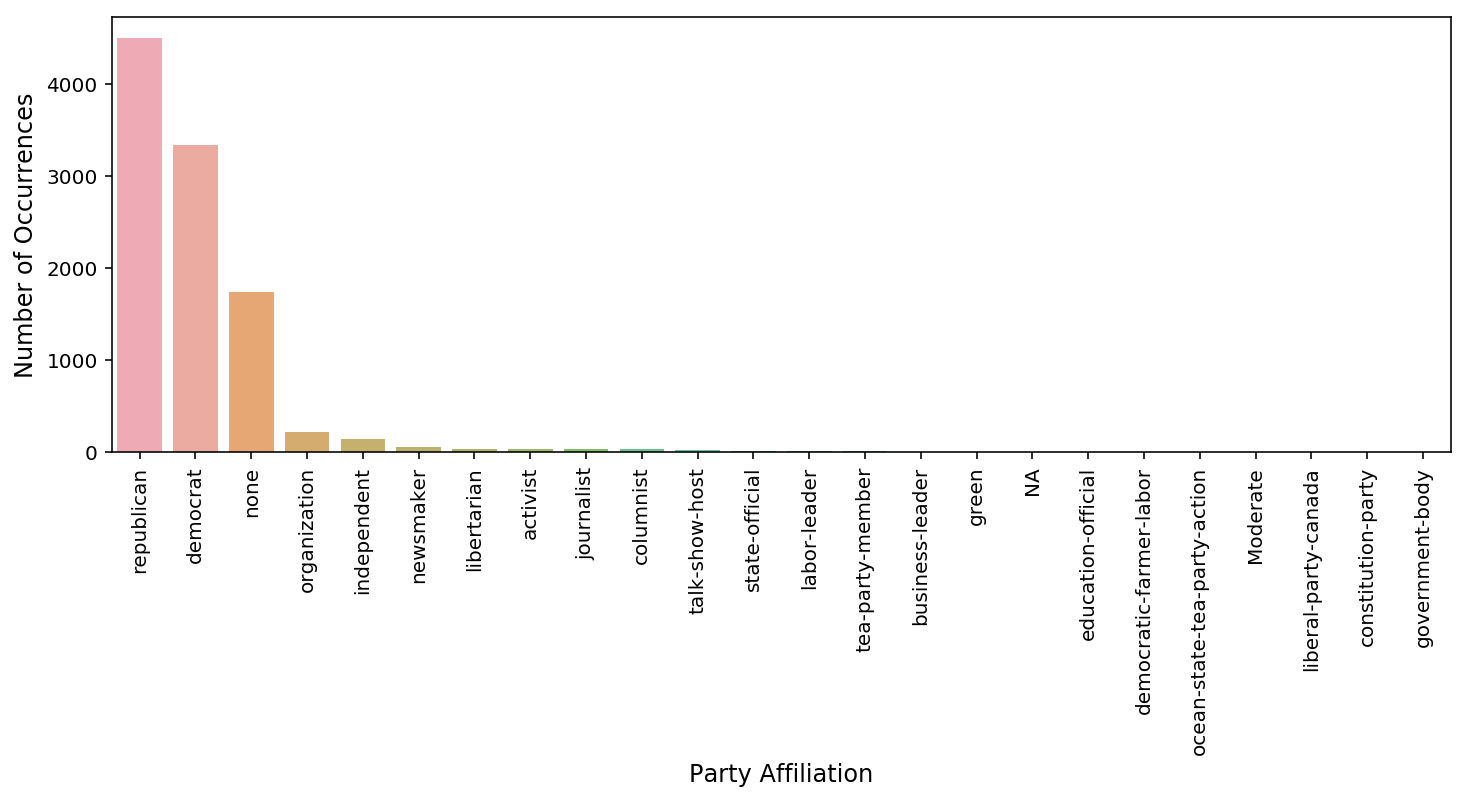

In [48]:
count_affiliation = train_data['Party Affiliation'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(count_affiliation.index, count_affiliation.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Party Affiliation', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [107]:
train_data.index = range(10240)

In [120]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [121]:
train_data.head()

,ID,Label,Statement,Subject,Speaker,Speakers Job Title,State Info,PartyAffiliation,Total credit history count,false counts,half true counts,mostly true counts,pants on fire counts,The Context
0,2635.json,false,say the anni list polit group support third-tr...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,when did the declin of coal start? it start wh...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"hillari clinton agre with john mccain ""bi vote...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,health care reform legisl is like to mandat fr...,health-care,blog-posting,NA,NA,none,7,19,3,5,44,a news release
4,9028.json,half-true,the econom turnaround start at the end of my t...,"economy,jobs",charlie-crist,NA,Florida,democrat,15,9,20,19,2,an interview on CNN


In [111]:
train_data.rename(columns = {'Party Affiliation':'PartyAffiliation'}, inplace = True)

# splitting dataset

In [122]:
X_train, X_test, y_train, y_test = train_test_split(train_data.Statement, train_data.PartyAffiliation, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [123]:
all_data[:2]

[TaggedDocument(words=['under', 'obamacare,', 'peopl', 'who', 'have', 'a', 'doctor', 'theyv', 'been', 'see', 'for', 'the', 'last', '15', 'or', '20', 'years,', 'they', 'wont', 'be', 'abl', 'to', 'keep', 'go', 'to', 'that', 'doctor.'], tags=['Train_0']),
 TaggedDocument(words=['middle-class', 'american', 'pay', 'a', 'higher', 'ta', 'rate', 'than', 'millionair', 'and', 'billionaires.'], tags=['Train_1'])]

# Training the model using Doc2Vec which icludes two algorithms "distributed bag of words" and "distributed memory"

In [124]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 10240/10240 [00:00<00:00, 1326958.72it/s]


In [125]:
from sklearn import utils

In [126]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 10240/10240 [00:00<00:00, 2282129.28it/s]


CPU times: user 24.3 s, sys: 4.47 s, total: 28.7 s
Wall time: 17.3 s


# function get the vectors

In [135]:
import numpy as np

def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [136]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

# Applying Logistic Regression on vectorized data from Doc2Vec

In [137]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [138]:
logreg.score(test_vectors_dbow, y_test)

0.4860026041666667

In [139]:
model_dbow.save('d2v_model_dbow.doc2vec')

# Distributed Memory - memory which remembers what is missing from topic of paragraph

In [140]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 10240/10240 [00:00<00:00, 1408139.83it/s]


In [141]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 10240/10240 [00:00<00:00, 2022112.66it/s]


CPU times: user 34.2 s, sys: 10 s, total: 44.3 s
Wall time: 24.5 s


In [142]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [143]:
logreg.fit(train_vectors_dm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [144]:
logreg.score(test_vectors_dm, y_test)

0.4534505208333333

In [145]:
model_dm.save('d2v_model_dm.doc2vec')

In [146]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [147]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [148]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

In [149]:
%%time
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

CPU times: user 19.9 s, sys: 201 ms, total: 20.1 s
Wall time: 21 s


In [150]:
logreg.score(test_vecs_dbow_dm, y_test)

0.4765625

In [80]:
logreg.score(test_vecs_dbow_dm, y_test)

0.4853515625

# Text Classification - Multi-Class classification problem


# classifying documents text based on party affliation


In [101]:
train_data_mul = train_data['Statement']
train_labels_mul = train_data['Party Affiliation']

test_data_mul = test_data['Statement']
test_labels_mul = test_data['Party Affiliation']

# Represent
vectorizer = TfidfVectorizer()
vectorised_train_data = vectorizer.fit_transform(train_data_mul)
vectorised_test_data = vectorizer.transform(test_data_mul)

# Train
classifier = LinearSVC()
classifier.fit(vectorised_train_data, train_labels_mul.astype(str))

# Predict
predictions = classifier.predict(vectorised_test_data)
print(predictions)

['republican' 'democrat' 'democrat' ... 'republican' 'democrat'
 'republican']


# Data Enrichment using movie reviews

# Text classification - positive and negative words from movie reviews

In [151]:
import nltk
import random
from nltk.corpus import movie_reviews

documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

print(documents[1])

all_words = []
for w in movie_reviews.words():
    all_words.append(w.lower())

all_words = nltk.FreqDist(all_words)
print(all_words.most_common(15))
print(all_words["stupid"])

(['the', 'only', 'two', 'really', 'good', 'things', 'that', 'i', 'can', 'say', 'about', 'tarzan', 'and', 'the', 'lost', 'city', 'are', 'as', 'follows', ':', 'jane', 'march', 'was', 'very', 'cute', 'as', 'jane', ',', 'and', 'the', 'movie', 'was', 'thankfully', 'under', '90', 'minutes', 'in', 'length', '.', 'if', 'you', 'haven', "'", 't', 'already', 'figured', 'it', 'out', ',', 'i', 'didn', "'", 't', 'like', 'this', 'movie', 'very', 'much', '.', 'the', 'plot', 'was', 'boring', 'and', 'contrived', 'to', 'the', 'extreme', '.', 'tarzan', '(', 'casper', 'van', 'dien', ')', 'has', 'now', 'left', 'the', 'jungle', 'and', 'living', 'in', 'civilized', 'society', '.', 'he', 'is', 'just', 'days', 'away', 'from', 'his', 'impending', 'marriage', 'to', 'jane', ',', 'played', 'by', 'the', 'aptly', 'named', 'jane', 'march', '.', 'back', 'in', 'his', 'former', 'home', 'of', 'africa', ',', 'a', 'group', 'of', 'looters', 'has', 'found', 'the', 'key', 'to', 'locating', 'a', 'lost', 'city', '.', '(', 'mind',

# converting above identified words to features

In [152]:
import nltk
import random
from nltk.corpus import movie_reviews

documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

all_words = []

for w in movie_reviews.words():
    all_words.append(w.lower())

all_words = nltk.FreqDist(all_words)

word_features = list(all_words.keys())[:3000]
print(word_features)
# function to find these top 3,000 words in our positive and negative documents, marking their presence as either positive or negative

def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', ',', 'drink', 'and', 'then', 'drive', '.', 'they', 'get', 'into', 'an', 'accident', 'one', 'of', 'the', 'guys', 'dies', 'but', 'his', 'girlfriend', 'continues', 'see', 'him', 'in', 'her', 'life', 'has', 'nightmares', 'what', "'", 's', 'deal', '?', 'watch', 'movie', '"', 'sorta', 'find', 'out', 'critique', 'mind', '-', 'fuck', 'for', 'generation', 'that', 'touches', 'on', 'very', 'cool', 'idea', 'presents', 'it', 'bad', 'package', 'which', 'is', 'makes', 'this', 'review', 'even', 'harder', 'write', 'since', 'i', 'generally', 'applaud', 'films', 'attempt', 'break', 'mold', 'mess', 'with', 'your', 'head', 'such', '(', 'lost', 'highway', '&', 'memento', ')', 'there', 'are', 'good', 'ways', 'making', 'all', 'types', 'these', 'folks', 'just', 'didn', 't', 'snag', 'correctly', 'seem', 'have', 'taken', 'pretty', 'neat', 'concept', 'executed', 'terribly', 'so', 'problems', 'well', 'its', 'main', 'problem', 'simply', 'to

# This code shows the trends of words in positive and negative reviews

In [153]:
print((find_features(movie_reviews.words('neg/cv000_29416.txt'))))

{'plot': True, ':': True, 'two': True, 'teen': True, 'couples': True, 'go': True, 'to': True, 'a': True, 'church': True, 'party': True, ',': True, 'drink': True, 'and': True, 'then': True, 'drive': True, '.': True, 'they': True, 'get': True, 'into': True, 'an': True, 'accident': True, 'one': True, 'of': True, 'the': True, 'guys': True, 'dies': True, 'but': True, 'his': True, 'girlfriend': True, 'continues': True, 'see': True, 'him': True, 'in': True, 'her': True, 'life': True, 'has': True, 'nightmares': True, 'what': True, "'": True, 's': True, 'deal': True, '?': True, 'watch': True, 'movie': True, '"': True, 'sorta': True, 'find': True, 'out': True, 'critique': True, 'mind': True, '-': True, 'fuck': True, 'for': True, 'generation': True, 'that': True, 'touches': True, 'on': True, 'very': True, 'cool': True, 'idea': True, 'presents': True, 'it': True, 'bad': True, 'package': True, 'which': True, 'is': True, 'makes': True, 'this': True, 'review': True, 'even': True, 'harder': True, 'wri

In [154]:
featuresets = [(find_features(rev), category) for (rev, category) in documents]
print(featuresets[1990:])

[({'plot': False, ':': True, 'two': False, 'teen': False, 'couples': False, 'go': True, 'to': True, 'a': True, 'church': False, 'party': False, ',': True, 'drink': False, 'and': True, 'then': True, 'drive': False, '.': True, 'they': True, 'get': True, 'into': False, 'an': True, 'accident': False, 'one': True, 'of': True, 'the': True, 'guys': False, 'dies': False, 'but': True, 'his': True, 'girlfriend': False, 'continues': False, 'see': True, 'him': True, 'in': True, 'her': False, 'life': False, 'has': True, 'nightmares': False, 'what': True, "'": True, 's': True, 'deal': False, '?': True, 'watch': True, 'movie': True, '"': True, 'sorta': False, 'find': True, 'out': True, 'critique': False, 'mind': False, '-': True, 'fuck': False, 'for': True, 'generation': False, 'that': True, 'touches': False, 'on': True, 'very': False, 'cool': True, 'idea': False, 'presents': False, 'it': True, 'bad': False, 'package': False, 'which': False, 'is': True, 'makes': True, 'this': True, 'review': False, '

# Applying Naive Bayes classifier as it recommended best for text classification

In [155]:
# set that we'll train our classifier with
training_set = featuresets[:1900]

# set that we'll test against.
testing_set = featuresets[1900:]

# Training the classifier

In [156]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

# Saving the classifier using pickle for future use and fast results

In [158]:
import pickle
save_classifier = open("naivebayes.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

# Above code saves the classifier for later use where we don't need to train the classifier again

# Using the saved classifier

In [159]:
classifier_f = open("naivebayes.pickle", "rb")
classifier = pickle.load(classifier_f)
classifier_f.close()

# Testing the classifier

In [160]:
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)

Classifier accuracy percent: 84.0


# Most valuable words are when it comes to positive or negative reviews:

In [161]:
classifier.show_most_informative_features(15)

Most Informative Features
                   sucks = True              neg : pos    =      9.8 : 1.0
                 frances = True              pos : neg    =      9.0 : 1.0
           unimaginative = True              neg : pos    =      8.3 : 1.0
                  annual = True              pos : neg    =      8.3 : 1.0
                    mena = True              neg : pos    =      7.0 : 1.0
                  suvari = True              neg : pos    =      7.0 : 1.0
                   groan = True              neg : pos    =      7.0 : 1.0
             silverstone = True              neg : pos    =      7.0 : 1.0
                 idiotic = True              neg : pos    =      6.8 : 1.0
              schumacher = True              neg : pos    =      6.6 : 1.0
               atrocious = True              neg : pos    =      6.6 : 1.0
                obstacle = True              pos : neg    =      6.3 : 1.0
                 singers = True              pos : neg    =      6.3 : 1.0

# Above result shows ratio of occurences of words in negative to positive, or visa versa,

# importing sklearn into NLTK

In [162]:
from nltk.classify.scikitlearn import SklearnClassifier

In [163]:
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

In [164]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, testing_set))

BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, testing_set))

MultinomialNB accuracy percent: 0.88
BernoulliNB accuracy percent: 0.84


In [165]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

In [166]:
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


Original Naive Bayes Algo accuracy percent: 84.0
Most Informative Features
                   sucks = True              neg : pos    =      9.8 : 1.0
                 frances = True              pos : neg    =      9.0 : 1.0
           unimaginative = True              neg : pos    =      8.3 : 1.0
                  annual = True              pos : neg    =      8.3 : 1.0
                    mena = True              neg : pos    =      7.0 : 1.0
                  suvari = True              neg : pos    =      7.0 : 1.0
                   groan = True              neg : pos    =      7.0 : 1.0
             silverstone = True              neg : pos    =      7.0 : 1.0
                 idiotic = True              neg : pos    =      6.8 : 1.0
              schumacher = True              neg : pos    =      6.6 : 1.0
               atrocious = True              neg : pos    =      6.6 : 1.0
                obstacle = True              pos : neg    =      6.3 : 1.0
                 singers 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 86.0
SVC_classifier accuracy percent: 86.0
LinearSVC_classifier accuracy percent: 87.0
NuSVC_classifier accuracy percent: 89.0


# combining classifiers to create vote classifier which selects best ML algo

In [167]:
from nltk.classify import ClassifierI
from statistics import mode

# Building classifier class:

In [168]:
class VoteClassifier:
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify_documents(self, documents):
        return [self.classify_many(doc) for doc in documents]
    
#creating function to vote
    def classify_many(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

#calculating confidence to tally the votes for and against the winning vote
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf

In [169]:
def my_accuracy(classifier, gold):
    documents, labels = zip(*gold)
    predictions = classifier.classify_documents(documents)
    correct = [y == y_hat for y, y_hat in zip(labels, predictions)]
    if correct:
        return sum(correct) / len(correct)
    else:
        return 0

In [170]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

all_words = []

for w in movie_reviews.words():
    all_words.append(w.lower())

all_words = nltk.FreqDist(all_words)

word_features = list(all_words.keys())[:3000]

def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

In [171]:
#print((find_features(movie_reviews.words('neg/cv000_29416.txt'))))

featuresets = [(find_features(rev), category) for (rev, category) in documents]
        
training_set = featuresets[:1900]
testing_set =  featuresets[1900:]

#classifier = nltk.NaiveBayesClassifier.train(training_set)

classifier_f = open("naivebayes.pickle","rb")
classifier = pickle.load(classifier_f)
classifier_f.close()
voted_classifier = VoteClassifier(classifier, 
                                  NuSVC_classifier,
                                  LinearSVC_classifier,
                                  SGDClassifier_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

my_accuracy(voted_classifier, testing_set)



print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)

##SVC_classifier = SklearnClassifier(SVC())
##SVC_classifier.train(training_set)
##print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)




print("voted_classifier accuracy percent:", (my_accuracy(voted_classifier, testing_set))*100)

print("Classification:", voted_classifier.classify_many(testing_set[0][0]), "Confidence %:",voted_classifier.confidence(testing_set[0][0])*100)
print("Classification:", voted_classifier.classify_many(testing_set[1][0]), "Confidence %:",voted_classifier.confidence(testing_set[1][0])*100)
print("Classification:", voted_classifier.classify_many(testing_set[2][0]), "Confidence %:",voted_classifier.confidence(testing_set[2][0])*100)
print("Classification:", voted_classifier.classify_many(testing_set[3][0]), "Confidence %:",voted_classifier.confidence(testing_set[3][0])*100)
print("Classification:", voted_classifier.classify_many(testing_set[4][0]), "Confidence %:",voted_classifier.confidence(testing_set[4][0])*100)
print("Classification:", voted_classifier.classify_many(testing_set[5][0]), "Confidence %:",voted_classifier.confidence(testing_set[5][0])*100)

Original Naive Bayes Algo accuracy percent: 90.0
Most Informative Features
                   sucks = True              neg : pos    =      9.8 : 1.0
                 frances = True              pos : neg    =      9.0 : 1.0
           unimaginative = True              neg : pos    =      8.3 : 1.0
                  annual = True              pos : neg    =      8.3 : 1.0
                    mena = True              neg : pos    =      7.0 : 1.0
                  suvari = True              neg : pos    =      7.0 : 1.0
                   groan = True              neg : pos    =      7.0 : 1.0
             silverstone = True              neg : pos    =      7.0 : 1.0
                 idiotic = True              neg : pos    =      6.8 : 1.0
              schumacher = True              neg : pos    =      6.6 : 1.0
               atrocious = True              neg : pos    =      6.6 : 1.0
                obstacle = True              pos : neg    =      6.3 : 1.0
                 singers 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 83.0
LinearSVC_classifier accuracy percent: 85.0
NuSVC_classifier accuracy percent: 88.0
voted_classifier accuracy percent: 98.0
Classification: neg Confidence %: 100.0
Classification: neg Confidence %: 100.0
Classification: neg Confidence %: 100.0
Classification: pos Confidence %: 100.0
Classification: pos Confidence %: 100.0
Classification: neg Confidence %: 57.14285714285714


#training twitter tweets for checking accuracy

In [172]:
import nltk
import random
from nltk.corpus import movie_reviews
from nltk.classify.scikitlearn import SklearnClassifier
import pickle

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from nltk.classify import ClassifierI
from statistics import mode

from nltk.tokenize import word_tokenize


class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf
        
short_pos = open("short_reviews/positive.txt","r", encoding='latin-1').read()
short_neg = open("short_reviews/negative.txt","r", encoding='latin-1').read()

documents = []

for r in short_pos.split('\n'):
    documents.append( (r, "pos") )

for r in short_neg.split('\n'):
    documents.append( (r, "neg") )


all_words = []

short_pos_words = word_tokenize(short_pos)
short_neg_words = word_tokenize(short_neg)

for w in short_pos_words:
    all_words.append(w.lower())

for w in short_neg_words:
    all_words.append(w.lower())

all_words = nltk.FreqDist(all_words)

word_features = list(all_words.keys())[:5000]

def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

#print((find_features(movie_reviews.words('neg/cv000_29416.txt'))))

featuresets = [(find_features(rev), category) for (rev, category) in documents]

random.shuffle(featuresets)

# positive data example:      
training_set = featuresets[:10000]
testing_set =  featuresets[10000:]

##
### negative data example:      
##training_set = featuresets[100:]
##testing_set =  featuresets[:100]


classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)

##SVC_classifier = SklearnClassifier(SVC())
##SVC_classifier.train(training_set)
##print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


voted_classifier = VoteClassifier(
                                  NuSVC_classifier,
                                  LinearSVC_classifier,
                                  MNB_classifier,
                                  BernoulliNB_classifier,
                                  LogisticRegression_classifier)

print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voted_classifier, testing_set))*100)

Original Naive Bayes Algo accuracy percent: 75.15060240963855
Most Informative Features
              engrossing = True              pos : neg    =     20.2 : 1.0
               inventive = True              pos : neg    =     15.6 : 1.0
                intimate = True              pos : neg    =     14.3 : 1.0
              refreshing = True              pos : neg    =     12.9 : 1.0
            refreshingly = True              pos : neg    =     12.9 : 1.0
                    warm = True              pos : neg    =     11.7 : 1.0
               realistic = True              pos : neg    =     11.6 : 1.0
             mesmerizing = True              pos : neg    =     11.6 : 1.0
              disturbing = True              pos : neg    =     11.6 : 1.0
                provides = True              pos : neg    =     10.9 : 1.0
                  stupid = True              neg : pos    =     10.7 : 1.0
               wonderful = True              pos : neg    =     10.5 : 1.0
            

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier_classifier accuracy percent: 72.28915662650603
LinearSVC_classifier accuracy percent: 72.89156626506023
NuSVC_classifier accuracy percent: 74.84939759036145
voted_classifier accuracy percent: 76.50602409638554


# creating a module for sentiment analysis

In [27]:
import nltk
import random
#from nltk.corpus import movie_reviews
from nltk.classify.scikitlearn import SklearnClassifier
import pickle
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify import ClassifierI
from statistics import mode
from nltk.tokenize import word_tokenize



class VoteClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        return mode(votes)

    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)

        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf
    
short_pos = open("short_reviews/positive.txt","r",encoding='latin-1').read()
short_neg = open("short_reviews/negative.txt","r",encoding='latin-1').read()

# move this up here
all_words = []
documents = []


#  j is adject, r is adverb, and v is verb
#allowed_word_types = ["J","R","V"]
allowed_word_types = ["J"]

for p in short_pos.split('\n'):
    documents.append( (p, "pos") )
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())

    
for p in short_neg.split('\n'):
    documents.append( (p, "neg") )
    words = word_tokenize(p)
    pos = nltk.pos_tag(words)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())



save_documents = open("pickled_algos/documents.pickle","wb")
pickle.dump(documents, save_documents)
save_documents.close()


all_words = nltk.FreqDist(all_words)


word_features = list(all_words.keys())[:5000]


save_word_features = open("pickled_algos/word_features5k.pickle","wb")
pickle.dump(word_features, save_word_features)
save_word_features.close()


def find_features(document):
    words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

featuresets = [(find_features(rev), category) for (rev, category) in documents]

save_featureset = open("pickled_algos/featuresets.pickle","wb")
pickle.dump(featuresets, save_featureset)
save_featureset.close()


random.shuffle(featuresets)
print(len(featuresets))

testing_set = featuresets[10000:]
training_set = featuresets[:10000]


classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

###############
save_classifier = open("pickled_algos/originalnaivebayes5k.pickle","wb")
pickle.dump(classifier, save_classifier)
save_classifier.close()

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos/MNB_classifier5k.pickle","wb")
pickle.dump(MNB_classifier, save_classifier)
save_classifier.close()

BernoulliNB_classifier = SklearnClassifier(BernoulliNB())
BernoulliNB_classifier.train(training_set)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BernoulliNB_classifier, testing_set))*100)

save_classifier = open("pickled_algos/BernoulliNB_classifier5k.pickle","wb")
pickle.dump(BernoulliNB_classifier, save_classifier)
save_classifier.close()

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)

save_classifier = open("pickled_algos/LogisticRegression_classifier5k.pickle","wb")
pickle.dump(LogisticRegression_classifier, save_classifier)
save_classifier.close()


LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)

save_classifier = open("pickled_algos/LinearSVC_classifier5k.pickle","wb")
pickle.dump(LinearSVC_classifier, save_classifier)
save_classifier.close()


##NuSVC_classifier = SklearnClassifier(NuSVC())
##NuSVC_classifier.train(training_set)
##print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


SGDC_classifier = SklearnClassifier(SGDClassifier())
SGDC_classifier.train(training_set)
print("SGDClassifier accuracy percent:",nltk.classify.accuracy(SGDC_classifier, testing_set)*100)

save_classifier = open("pickled_algos/SGDC_classifier5k.pickle","wb")
pickle.dump(SGDC_classifier, save_classifier)
save_classifier.close()

10664
Original Naive Bayes Algo accuracy percent: 71.6867469879518
Most Informative Features
              engrossing = True              pos : neg    =     20.3 : 1.0
                mediocre = True              neg : pos    =     15.7 : 1.0
                 routine = True              neg : pos    =     15.7 : 1.0
                 generic = True              neg : pos    =     15.7 : 1.0
               inventive = True              pos : neg    =     15.6 : 1.0
              unexpected = True              pos : neg    =     15.0 : 1.0
                    flat = True              neg : pos    =     14.6 : 1.0
                  boring = True              neg : pos    =     13.3 : 1.0
                    warm = True              pos : neg    =     13.0 : 1.0
              refreshing = True              pos : neg    =     13.0 : 1.0
               wonderful = True              pos : neg    =     12.6 : 1.0
                    dull = True              neg : pos    =     12.5 : 1.0
       

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier accuracy percent: 69.27710843373494


In [39]:
from sentiment_mod import sentiment

print(sentiment("This movie was awesome! The acting was great, plot was wonderful, and there were pythons...so yea!"))
print(sentiment("This movie was utter junk. There were absolutely 0 pythons. I don't see what the point was at all. Horrible movie, 0/10"))
print(sentiment("Says the Annies List political group supports third-trimester abortions on demand."))

('pos', 1.0)
('neg', 1.0)
('pos', 1.0)


In [ ]:
# sentiment analysis using a module in turn reduced execution time

In [49]:
statements = train_data['Statement']
for st in statements:
    print(sentiment(st))

('pos', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)

('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('pos', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('pos', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 0.6)
('neg', 1.0)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 0.8)
('pos', 0.6)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)

('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.6)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)

('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 0.6)
('neg', 1.0)

('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)

('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)

('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.6)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.8)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('pos', 0.6)

('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('pos', 0.6)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)

('neg', 0.8)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('pos', 0.8)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('pos', 1.0)
('pos', 0.8)
('pos', 0.6)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)

('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('pos', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.8)
('neg', 0.6)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 0.6)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)

('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.6)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)

('neg', 1.0)
('neg', 1.0)
('pos', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('pos', 0.6)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('pos', 0.6)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)

('neg', 0.8)
('pos', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.8)
('neg', 0.6)
('neg', 0.6)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.6)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)

('pos', 0.8)
('pos', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('pos', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.6)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 0.8)
('neg', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)

('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('pos', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('pos', 0.6)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('pos', 0.6)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)

('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('pos', 0.6)
('neg', 0.8)
('pos', 0.8)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('pos', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)

('neg', 0.6)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('pos', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('pos', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 0.8)
('pos', 1.0)
('neg', 1.0)
('pos', 0.6)
('pos', 1.0)
('pos', 0.8)
('pos', 1.0)
('pos', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('neg', 0.6)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 1.0)
('pos', 0.6)
('neg', 1.0)
('neg', 0.8)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('pos', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('neg', 1.0)
('neg', 0.8)
('pos', 1.0)
('neg', 0.8)
('pos', 1.0)